# Tsodyks short-term plasticity

Tutor: Johanna Senk [<span>&#9993;</span>](mailto:j.senk@sussex.ac.uk)

We use the synapse model `tsodyks_synapse` which implements synaptic short-term depression and short-term facilitation according to Tsodyks et al. (2000).  
For details, refer to the [NEST documentation](https://nest-simulator.readthedocs.io/en/stable/models/tsodyks_synapse.html).

This notebook is based on the NEST examples
[Tsodyks depressing example](https://nest-simulator.readthedocs.io/en/stable/auto_examples/tsodyks_depressing.html)
and
[Tsodyks facilitating example](https://nest-simulator.readthedocs.io/en/stable/auto_examples/tsodyks_facilitating.html).  
An earlier version of the notebook was developed by Agnes Korcsak-Gorzo for BNNI 2022.

## Background

<img src="MorrisonEtAl2008_Fig2B.png" alt="Morrison et al. (2008) Fig. 2B" width="50" align="center"/>

If neuron $i$ receives a synapse from neuron $j$, the synaptic current (or conductance) in neuron $i$ is $w_{ij}y_{ij}(t)$, where $w_{ij}$ is the absolute strength and $y_{ij}(t)$ is a scaling factor that describes the momentary input to neuron $i$.

Dropping indices, $x$,$y$ and $z$ are the fractions of synaptic resources in the recovered, active, and inactive states, respectively, and they evolve as follows:
\begin{align}
\frac{dx}{dt} &= \frac{z}{\tau_\text{rec}} - u_+ x_- \delta(t - t_j^f)\\
\frac{dy}{dt} &= -\frac{y}{\tau_\text{I}} + u_+ x_- \delta(t - t_j^f)\\
\frac{dz}{dt} &= \frac{y}{\tau_\text{I}} - \frac{z}{\tau_\text{rec}}
\end{align}

$t_j^f$ gives the timing of presynaptic spikes, $\tau_\text{I}$ is the decay constant of PSCs and $\tau_\text{rec}$ is the recovery time from synaptic depression. A fraction $u_+$ of the available resources $x$ is used by each presynaptic spike. The variable $u_+$ therefore describes the effective use of the synaptic resources of the synapses, which is analogous to the probability of release in the model described by Markram et al. (1998).

Synaptic depression is motivated by depletion of vesicles in the readily releasable pool of synaptic vesicles (variable $x$).

In facilitating synapses, $u_+$ is not a fixed parameter, but derived from a variable $u$ which is increased with each presynaptic spike and returns to baseline with a time constant $\tau_{fac}$:

\begin{align}
\frac{du}{dt} &= -\frac{u}{\tau_\text{fac}} + U(1-u_-) \delta(t - t_j^f)\\
\end{align}

Synaptic facilitation comes about by a presynaptic increase of release probability due to the facilitation parameter $U$.

(Note: The subscript + means that a value is taken just after an update, and - means just before.)

### References

**Plasticity mechanism**

*Tsodyks M, Uziel A, Markram H (2000)*. Synchrony generation in recurrent networks with frequency-dependent synapses. Journal of Neuroscience, 20 RC50. [doi:10.1523/JNEUROSCI.20-01-j0003.2000](https://doi.org/10.1523/JNEUROSCI.20-01-j0003.2000)

*Tsodyks M, Pawelzik K, Markram H (1998). Neural networks with dynamic synapses. Neural computation. [doi:10.1162/089976698300017502](https:/doi.org/10.1162/089976698300017502)*

**NEST implementation**

*A. Morrison, M. Diesmann, and W. Gerstner.  Phenomenological models of synaptic plasticity based on spike timing. Biological Cybernetics, 98(6):459–478, 2008. [doi:10.1007/s00422-008-0233-1](https://doi.org/10.1007/s00422-008-0233-1)*

## This notebook

We will simulate three pairs of neurons connected by a 1.) a static synapse, 2.) a facilitating Tsodyks synapse, and 3.) a depressing Tsodyks synapse.  
The first neuron of each pair is driven by DC input and we record the membrane potential of the second neuron.

**1. Static synapse**  
The static synapse uses a fixed weight.

**2. Tsodyks facilitating synapse**  
A small facilitation parameter `U` causes a slow saturation of the synaptic efficacy, enabling a facilitating behavior.  This experiment could reproduce Figure 1B of Tsodyks et al. (1998), but for simplicity we here use the parameters of Figure 1A throughout.

**3. Tsodyks depressing synapse**
A large facilitation parameter `U` causes a fast saturation of the synaptic efficacy, disabling a facilitating behavior.  
This experiment reproduces Figure 1A of Tsodyks et al. (1998).

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import nest
nest.set_verbosity('M_ERROR')

[R90W6AA2:15591] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Mar 31 2024 20:12:01

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Set simulation parameters:

In [2]:
resolution = 0.1            # simulation step size (ms)
sim_time = 1200.            # simulation time
dc_start = 50.              # start time of DC input
dc_stop = 1050.             # stop time of DC input

The neurons are of type `iaf_psc_exp`. Set the neuron parameters:

In [3]:
tau_syn = 3.                # note: NEST facilitation example uses 1.5

nrn_params = {
    'tau_m': 40.,           # membrane time constant (ms)
    't_ref': 2.,            # refractory time (ms)
    'tau_syn_ex': tau_syn,  # exc. synaptic time constant (ms)
    'tau_syn_in': tau_syn,  # inh. synaptic time constant (ms)
    'C_m': 400.,            # membrane capacitance (nF); note: NEST facilitation examples uses 40.
    'V_reset': 0.,          # reset potential of membrane potential (mV)
    'E_L': 0.,              # leak potential (mV)
    'V_m': 0.,              # initial membrane potential (mV)
    'V_th': 15.,            # threshold membrane potential (mV)
    }

Check the default values of the synapse model `tsodyks_synapse`:

In [4]:
nest.GetDefaults('tsodyks_synapse')

{'delay': 1.0,
 'U': 0.5,
 'element_type': 'synapse',
 'has_delay': True,
 'num_connections': 0,
 'receptor_type': 0,
 'requires_symmetric': False,
 'sizeof': 96,
 'synapse_model': 'tsodyks_synapse',
 'synapse_modelid': 62,
 'tau_fac': 0.0,
 'tau_psc': 3.0,
 'tau_rec': 800.0,
 'u': 0.0,
 'weight': 1.0,
 'weight_recorder': NodeCollection(<empty>),
 'x': 1.0,
 'y': 0.0}

To reproduce results from the original studies, `tau_psc` should be equal to `tau_syn_ex` in the neuron model.

Set the synapse specifications:

In [5]:
# static synapse
syn_spec_static = {'synapse_model': 'static_synapse', 'weight': 1.}

# facilitating Tsodyks synapse
syn_spec_fac = {
    'tau_psc': tau_syn,     # PSC time constant (ms)
    'tau_rec': 130.,        # recovery time (ms)
    'tau_fac': 530.,        # facilitation time (ms)
    'U': 0.03,              # facilitation parameter, asymptotic value of release probability, increase in u with each spike [0,1]
    'delay': 0.1,           # synaptic delay (ms)
    'weight': 1540.,        # PSC weight (pA)
    'u': 0.,                # actual release probability
    'x': 1.,                # initial fraction of resources (= synaptic vesicles) in the recovered state (= readily releasable pool) [0,1]
    'y': 0.                 # initial fraction of synaptic vesicles in the synaptic cleft [0,1]
    }

# depressing Tsodyks synapse
syn_spec_dep = {
    'tau_psc': tau_syn,     # PSC time constant (ms)
    'tau_rec': 800.,        # recovery time (ms)
    'tau_fac': 0.,          # facilitation time (ms)
    'U': 0.5,               # facilitation parameter, asymptotic value of release probability, increase in u with each spike [0,1]
    'delay': 0.1,           # synaptic delay (ms)
    'weight': 250.,         # PSC weight (pA)
    'u': 0.,                # actual release probability
    'x': 1.,                # initial fraction of resources (= synaptic vesicles) in the recovered state (= readily releasable pool) [0,1]
    'y': 0.                 # initial fraction of synaptic vesicles in the synaptic cleft [0,1]
    }

Instead of providing input spikes with a given frequency, we use DC current input:

In [6]:
p = nrn_params.copy()
f = 0.02                    # frequency (kHz)

I0 = p['V_th'] * p['C_m'] / p['tau_m'] / (1 - np.exp(-(1 / f - p['t_ref']) / p['tau_m']))

Let's set up three network in NEST. First, we need to clear the NEST memory:

In [7]:
nest.ResetKernel()
nest.resolution = resolution

Here, we create and configure neurons and devices.  
The first neuron of each pair receives DC input and from the second neuron we will record the membrane voltages.

In [8]:
nrns = nest.Create('iaf_psc_exp', 6, nrn_params)

dc_gen = nest.Create('dc_generator', 3, {'amplitude': I0, 'start': dc_start, 'stop': dc_stop})

vm = nest.Create('voltmeter', 3, {'label': 'voltmeter', 'interval': 1.})

Connect neurons and devices:

In [9]:
nest.CopyModel('tsodyks_synapse', 'syn_fac', syn_spec_fac)
nest.CopyModel('tsodyks_synapse', 'syn_dep', syn_spec_dep)

# static synapse
nest.Connect(dc_gen[0], nrns[0])
nest.Connect(vm[0], nrns[1])
nest.Connect(nrns[0], nrns[1], syn_spec=syn_spec_static)

# facilitating Tsodyks synapse
nest.Connect(dc_gen[1], nrns[2])
nest.Connect(vm[1], nrns[3])
nest.Connect(nrns[2], nrns[3], syn_spec='syn_fac')

# depressing Tsodyks synapse
nest.Connect(dc_gen[2], nrns[4])
nest.Connect(vm[2], nrns[5])
nest.Connect(nrns[4], nrns[5], syn_spec='syn_dep')

Simulate:

In [11]:
nest.Simulate(sim_time)

Read out the membrane potentials recorded from the second neuron of each pair:

In [12]:
nrn_static_t = vm[0].events['times']
nrn_static_v = vm[0].events['V_m']
nrn_static_senders = vm[0].events['senders']

nrn_fac_t = vm[1].events['times']
nrn_fac_v = vm[1].events['V_m']
nrn_fac_senders = vm[1].events['senders']

nrn_dep_t = vm[2].events['times']
nrn_dep_v = vm[2].events['V_m']
nrn_dep_senders = vm[2].events['senders']

Plot time courses of membrane potentials.

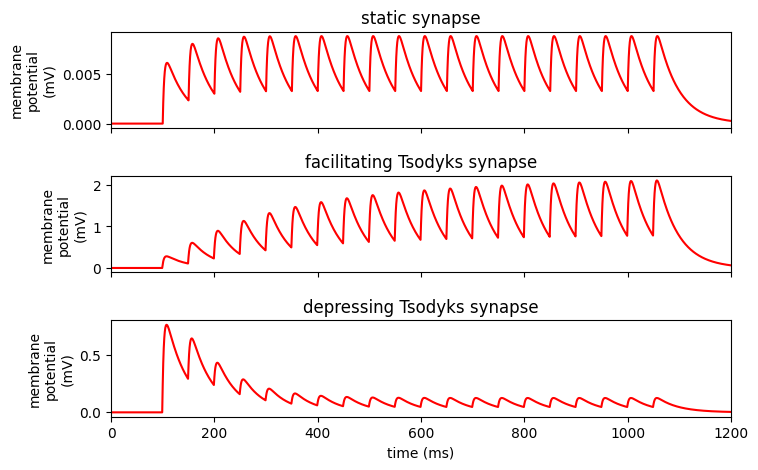

In [13]:
fig, axs = plt.subplots(3, figsize=(8, 5))
fig.subplots_adjust(hspace=0.5)

axs[0].set_title('static synapse')
axs[0].plot(nrn_static_t, nrn_static_v, c='r')

axs[1].set_title('facilitating Tsodyks synapse')
axs[1].plot(nrn_fac_t, nrn_fac_v, c='r')

axs[2].set_title('depressing Tsodyks synapse')
axs[2].plot(nrn_dep_t, nrn_dep_v, c='r')

axs[0].set_xticklabels([])
axs[1].set_xticklabels([])

axs[2].set_xlabel('time (ms)')
for ax in axs:
    ax.set_ylabel('membrane\npotential\n(mV)')
    ax.set_xlim(0, sim_time)

Side remark: you can even more conveniently use the built-in plotting functions of NEST:

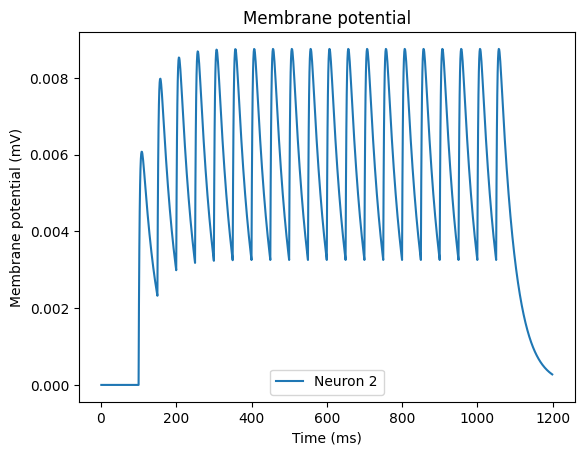

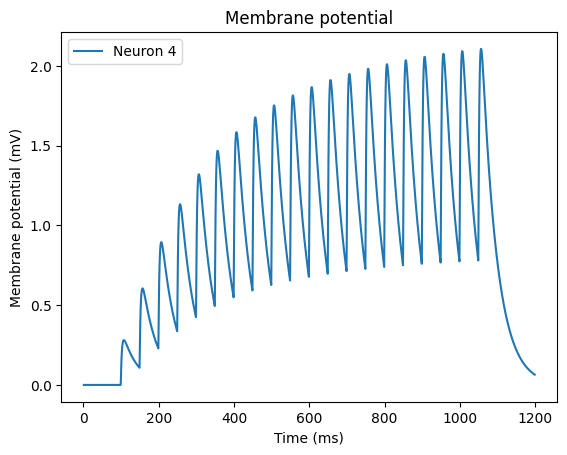

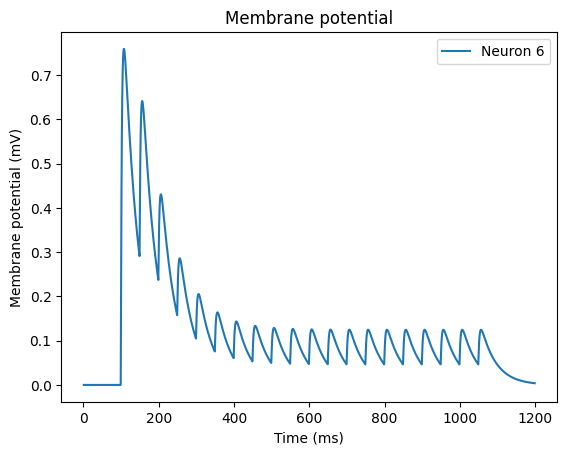

In [16]:
import nest.voltage_trace

_ = nest.voltage_trace.from_device(vm[0])
plt.show()

_ = nest.voltage_trace.from_device(vm[1])
plt.show()

a = nest.voltage_trace.from_device(vm[2])
plt.show()